### Experiment 2: Inferring the rule when multiple rules are in place

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
from pathlib import Path

import pandas as pd 

import hippo
from hippo.agents import HierarchicalAgent, AgentModes, load_hippo_agent, load_prefrontal_agent
from hippo.environments.action_perception import action_perception_loop
from hippo.environments.w_maze import get_wmaze, WmazeTasks

pygame 2.5.2 (SDL 2.28.3, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
store_path = Path(hippo.__file__).parent.parent / "data/results/experiment-2"
store_path.mkdir(exist_ok=True, parents=True)

def to_dataframe(logs, control_mode, agent_name, trial):
    d_new = {
        "trial": [trial for _ in range(len(logs["action"]))],
        "agent_name": [agent_name for _ in range(len(logs["action"]))],
        "control_mode": [control_mode for _ in range(len(logs["action"]))],
        "time": np.arange(len(logs["action"])),
        "action": logs["action"],
        "reward": 1.0 * logs["reward"],
        "pos_x": [pose[0] for pose in logs["pose"]],
        "pos_y": [pose[1] for pose in logs["pose"]],
        "pos_dir": [pose[2] for pose in logs["pose"]],
        "rules": logs["rules"],
        "inbound": logs["inbound"],
        "qs_pfc": [lo.get('qs', None) for lo in logs['agent_info']]
    }
    return pd.DataFrame.from_dict(d_new)

In [11]:
from tqdm import trange

def run_experiment(agent_mode, store_path, n_trials=20, n_steps=300, cycle=True):
    """
    Runs the action control loop for an agent for multiple trials. 
    A control and disruption scenario is ran and the metrics are stored
    unless the agent is random (does not use state to select action) 
    """
    model_hippo = load_hippo_agent()
    model_pf = load_prefrontal_agent(agent_mode=agent_mode)

    agent = HierarchicalAgent(
        model_pf=model_pf,
        model_hippo=model_hippo,
        fe_threshold=-14.8,
        name=agent_mode.name,
    )

    cycle_every = 300 if cycle else n_steps
    n_rules = 3 if cycle else 1

    run_logs_df = pd.DataFrame()
    for trial in range(n_trials):
        control_key = "control"

        run_logs = action_perception_loop(
            get_wmaze(
                task_mode=WmazeTasks.TASK0, 
                cycle_rules_every=cycle_every, 
                cycle_rules_random=True,
                n_rules=n_rules
            ),
            agent,
            n_steps,
            record_frames=False,
            record_agent_info=True,
            observable_reward=True,
            callbacks=[],
            observable_light=False,
            progress_bar=True
        )

        df = to_dataframe(run_logs, control_key, agent.name, trial)
        run_logs_df = pd.concat([run_logs_df, df])

    n_rules = "multiple_rules" if cycle else "single_rule"
    run_logs_df.to_csv(store_path / f"{agent_mode}_{n_rules}.csv")

In [5]:
n_steps = 900
n_trials = 20

In [ ]:
run_experiment(
    AgentModes.RANDOM, 
    store_path, 
    n_trials=n_trials, 
    n_steps=n_steps, 
    cycle=True
)

run_experiment(
    AgentModes.RANDOM, 
    store_path, 
    n_trials=n_trials, 
    n_steps=n_steps, 
    cycle=False
)

In [6]:
run_experiment(
    AgentModes.CSCG_LOC, 
    store_path, 
    n_trials=n_trials, 
    n_steps=n_steps, 
    cycle=True
)

# run_experiment(
    # AgentModes.CSCG_LOC, 
    # store_path, 
    # n_trials=n_trials, 
    # n_steps=n_steps, 
    # cycle=False
# )

/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 900/900 [01:18<00:00, 11.48it/s]


In [12]:
run_experiment(
    AgentModes.CSCG_LOC_RULE0, 
    store_path, 
    n_trials=n_trials, 
    n_steps=n_steps, 
    cycle=True
)

# run_experiment(
#     AgentModes.CSCG_LOC_RULE0, 
#     store_path, 
#     n_trials=n_trials, 
#     n_steps=n_steps, 
#     cycle=False
# )

/Users/toon.vandemaele/.pyenv/versions/3.11.6/envs/hippo/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 900/900 [01:22<00:00, 10.86it/s]


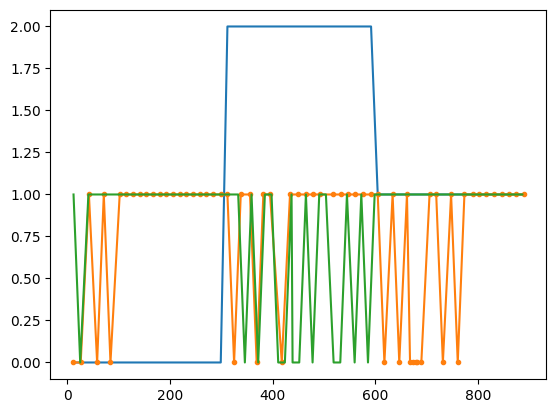

,Unnamed: 0,trial,agent_name,control_mode,time,action,reward,pos_x,pos_y,pos_dir,rules,inbound,qs_pfc
0,0,0,CSCG_LOC_RULE0,control,0,1,0.0,7,1,0,0,False,"[array([0.03125, 0.03125, 0.03125, 0.03125, 0...."
1,1,0,CSCG_LOC_RULE0,control,1,2,1.0,7,1,1,0,True,NaN
2,2,0,CSCG_LOC_RULE0,control,2,2,0.0,7,2,1,0,True,NaN
3,3,0,CSCG_LOC_RULE0,control,3,2,0.0,7,3,1,0,True,NaN
4,4,0,CSCG_LOC_RULE0,control,4,1,0.0,7,4,1,0,True,NaN


In [13]:
import matplotlib.pyplot as plt

data = pd.read_csv(store_path / "CSCG_LOC_multiple_rules.csv")

fil = data[data['trial'] == 0]
fil = fil[fil['agent_name'] == "CSCG_LOC"]

fil = fil[fil["pos_y"] == 1]
fil = fil[fil["pos_dir"] == 3]
x = np.array(fil['time'].tolist())
y = np.array(fil['rules'].tolist())
plt.plot(x[x.argsort()], y[x.argsort()])

x = np.array(fil['time'].tolist())
y = np.array(fil['reward'].tolist())
plt.plot(x[x.argsort()], y[x.argsort()], marker='.')

data = pd.read_csv(store_path / "CSCG_LOC_RULE0_multiple_rules.csv")
fil = data[data['trial'] == 0]
fil = fil[fil['agent_name'] == "CSCG_LOC_RULE0"]
fil = fil[fil["pos_y"] == 1]
fil = fil[fil["pos_dir"] == 3]
x = np.array(fil['time'].tolist())
y = np.array(fil['reward'].tolist())
plt.plot(x[x.argsort()], y[x.argsort()])

plt.show()

data.head()

,Unnamed: 0,trial,agent_name,control_mode,time,action,reward,pos_x,pos_y,pos_dir,rules,inbound,qs_pfc
0,0,0,CSCG_LOC,control,0,2,0.0,3,4,2,0,False,"[array([0.01694915, 0.01694915, 0.01694915, 0...."
1,1,0,CSCG_LOC,control,1,2,0.0,2,4,2,0,False,NaN
2,2,0,CSCG_LOC,control,2,1,0.0,1,4,2,0,False,NaN
3,3,0,CSCG_LOC,control,3,2,0.0,1,4,3,0,False,NaN
4,4,0,CSCG_LOC,control,4,2,0.0,1,3,3,0,False,NaN


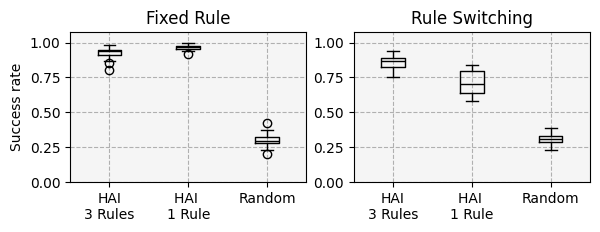

In [14]:
import matplotlib.pyplot as plt
from hippo.visualization import format_ax

def plot_performance():
    df_mr = pd.DataFrame()
    df_sr = pd.DataFrame()
    for mode in AgentModes:
        try: 
            data = pd.read_csv(store_path / f"{mode}_multiple_rules.csv")
            df_mr = pd.concat([df_mr, data])

            data = pd.read_csv(store_path / f"{mode}_single_rule.csv")
            df_sr = pd.concat([df_sr, data])
        except:
            pass
        
    corridors = df_mr[df_mr["pos_y"] == 1]
    corridors = corridors[corridors["pos_dir"] == 3]
    corridors = corridors[corridors["control_mode"] == "control"]
    grouped_mr = corridors.groupby(["agent_name", "trial"]).mean(["reward"])

    corridors = df_sr[df_sr["pos_y"] == 1]
    corridors = corridors[corridors["pos_dir"] == 3]
    corridors = corridors[corridors["control_mode"] == "control"]
    grouped_sr = corridors.groupby(["agent_name", "trial"]).mean(["reward"])

    fig, ax = plt.subplots(1,2,figsize=(6.5, 2))

    grouped_mr.boxplot(['reward'], by=['agent_name'], ax=ax[1], color='black')
    ax[1].set_title("Rule Switching")

    grouped_sr.boxplot(['reward'], by=['agent_name'], ax=ax[0], color='black')
    ax[0].set_title("Fixed Rule")

    ax[0].set_ylabel("Success rate")

    for a in ax.flatten():
        a.set_xticklabels(["HAI\n3 Rules", "HAI \n1 Rule", "Random"], rotation=0)
        a.set_xlabel("")
        a.set_ylim([0.0, 1.075])
        format_ax(a)

    plt.suptitle("")
    plt.savefig(store_path / "cyclic_rules_boxplot.svg", bbox_inches='tight')


    return df_sr


plot_performance().head()


In [16]:
data = pd.read_csv(store_path / f"CSCG_LOC_multiple_rules.csv")

corridors = data[data["pos_y"] == 1]
corridors = corridors[corridors["pos_dir"] == 3]
corridors = corridors[corridors["control_mode"] == "control"]

times = []
corridor_times = []
for trial in corridors['trial'].unique(): 
    fil_trial = corridors[corridors['trial'] == trial]
    for i in range(0, n_steps, 300): 
        fil = fil_trial[fil_trial['time'] > i]
        fil = fil[fil['time'] < i+300]
        rew = 0
        for j, (r, t) in enumerate(zip(fil['reward'].tolist(), fil['time'].tolist())):
            rew = (rew + r) * r
            if rew >= 4:
                times.append(t-i)
                corridor_times.append(j-4)
                break
        else: 
            times.append(t)

print("in # low level tiles", np.mean(times), np.std(times))
print("in # corridors", np.mean(corridor_times), np.std(corridor_times))

in # low level tiles 124.68333333333334 40.4291527104995
in # corridors 4.483333333333333 3.0522760178084956
